<a id=contents></a>

# Latent Dirichlet Allocation on Web-scraped data

## Finding topics from raw data



In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')


from sklearn.decomposition import LatentDirichletAllocation as LDA
      
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

import functions as fn
import topic_mod as topic


%load_ext autoreload
%autoreload 2

<a id=prev ><a/> 

## 1. Most prevalent words
    

In [3]:
df = pd.read_csv('jobs.csv', index_col=0)

In [5]:
stop_words = fn.gen_stopwords(['data', 'scientist', 'machine', 'analyst'])

In [14]:
%%time

number_topics = 10

count_vect_lem = CountVectorizer(tokenizer=fn.LemmaTokenizer(tokenizer, stop_words),
                       strip_accents = 'unicode',
                       stop_words = stop_words,
                       lowercase = True,)

lda = LDA(n_components=number_topics,
          doc_topic_prior = 1,
          topic_word_prior = 0.05,
          n_jobs=-1, random_state=12345)



lda_data, lda_obj = topic.data_to_lda(df, 13, 'job_descr', count_vect_lem, lda, )

number_words = 20

# Print the topics found by the LDA model
print("Topics found via LDA on Count Vectorised data for ALL categories:")
topic.print_topics(lda_obj, count_vect_lem, number_words)

Topics found via LDA on Count Vectorised data for ALL categories:

Topic #1:
software; experience; amazon; learning; opportunity; team; application; business; work; product; engineer; problem; development; technical; make; personal; process; skill; working; science

Topic #2:
learning; research; experience; science; team; role; work; working; model; skill; deep; please; language; python; nlp; quantitative; technique; candidate; algorithm; researcher

Topic #3:
learning; work; team; time; company; causalens; business; high; platform; exciting; award; day; development; approach; best; holiday; fund; mission; opportunity; problem

Topic #4:
client; business; team; work; people; opportunity; service; financial; role; value; investment; experience; firm; market; skill; management; make; global; working; support

Topic #5:
experience; team; development; technology; software; work; working; learning; engineer; science; system; engineering; skill; platform; application; big; new; business; inc

## 2. Visualising with pyLDAvis

In [6]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [15]:
%%time

display_data = pyLDAvis.sklearn.prepare(lda_obj, 
                         count_vect_lem.fit_transform(df['job_descr']),
                        count_vect_lem)

CPU times: user 13.1 s, sys: 65.6 ms, total: 13.1 s
Wall time: 14.6 s


In [16]:
pyLDAvis.display(display_data)

Just to give you a better idea of what the data looks like, here are the 5 bottom rows. I've excluded the text columns at the left-end because they skewed the table dimensions. 

In [17]:
lda_data.iloc[:,4:].tail()

,job_location,searched_data_analyst,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,id,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
2206,London,1,0,0,60000.0,31.61,Y,3.0,2206,0.017287,0.009881,0.008854,0.011916,0.070315,0.070180,0.010867,0.227657,0.332129,0.240914
2207,London,1,0,0,NaN,NaN,NaN,NaN,2207,0.014893,0.511001,0.019440,0.049220,0.014698,0.019979,0.161388,0.152715,0.013482,0.043185
2208,London,1,0,0,95000.0,50.05,Y,9.0,2208,0.075084,0.018655,0.015952,0.047747,0.015050,0.025473,0.256817,0.335103,0.186997,0.023121
2209,London,1,0,0,300.0,41.10,D,2.0,2209,0.012937,0.012911,0.009553,0.171619,0.106706,0.015927,0.005163,0.095259,0.419724,0.150200
2210,London,1,0,0,NaN,NaN,NaN,1775.0,2210,0.029434,0.006101,0.014811,0.229877,0.171783,0.059898,0.009494,0.008003,0.411682,0.058916


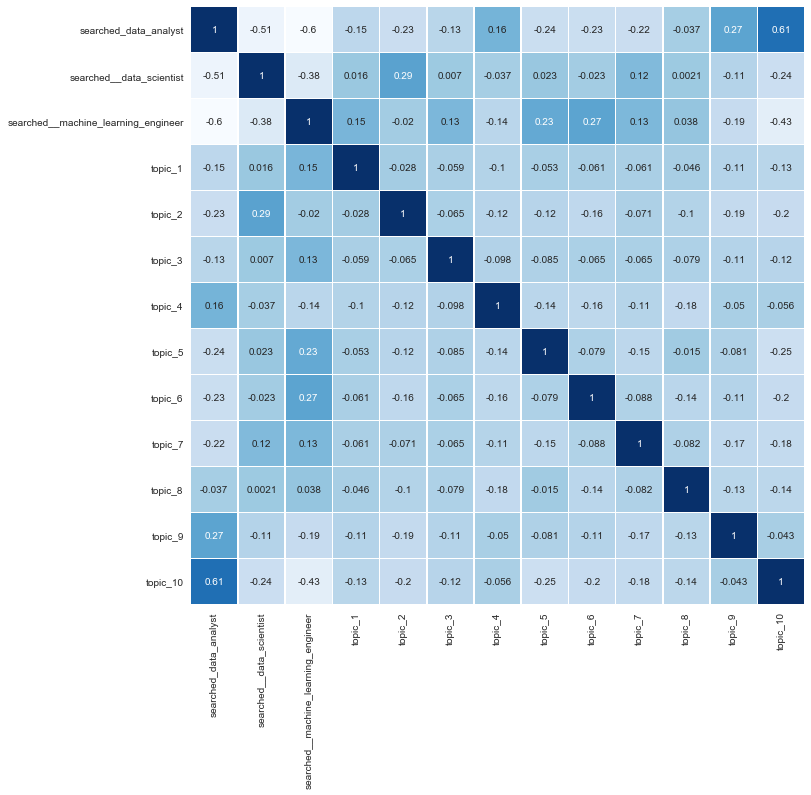

In [18]:
plt.figure(figsize=(11,11))
plot = sns.heatmap(lda_data[['searched_data_analyst', 'searched__data_scientist', 'searched__machine_learning_engineer', 
                     'topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8',
                     'topic_9', 'topic_10']].corr(), annot=True, linewidths=0.5, cbar=False, cmap='Blues')
fig=plot.get_figure()

fig.savefig('fig/heatmap_lda.jpeg')

Another great thing about pyLDAvis is that you can also save the plot as an html file that can be uploaded to a web server and then shared.

In [96]:
pyLDAvis.save_html(display_data, 'jobs_lda_vis.html')

The html file saved can then be viewed directly from browser. Have fun with pyLDAvis and LDirA in general!!

## 3. Bigrams!!!
As with any good NLP project, you will benefit massively from tweaking your pre-processing. We'll repeat a lot of the process but this time with bigrams. Note that this will take considerably longer for LDA to run (just look at the wall-time at the bottom of cell output for an idea). 

In [7]:
%%time

number_topics = 10

count_vect_lem_bigram = CountVectorizer(tokenizer=fn.LemmaTokenizer(tokenizer, stop_words),
                       strip_accents = 'unicode',
                       stop_words = stop_words,
                       lowercase = True, ngram_range=(2,2))

lda_bigram = LDA(n_components=number_topics,
          doc_topic_prior = 1,
          topic_word_prior = 0.05,
          n_jobs=-1, random_state=12345)



lda_data_bigram, lda_obj_bigram = topic.data_to_lda(df, 13, 'job_descr', count_vect_lem_bigram, lda_bigram, )

number_words = 20

CPU times: user 2min 4s, sys: 1min 7s, total: 3min 12s
Wall time: 4min 20s


In [9]:
%%time

display_data_bigram = pyLDAvis.sklearn.prepare(lda_bigram, 
                         count_vect_lem_bigram.fit_transform(df['job_descr']),
                        count_vect_lem_bigram)
pyLDAvis.display(display_data_bigram)

CPU times: user 2min 9s, sys: 1.19 s, total: 2min 10s
Wall time: 2min 27s
